In [2]:
import requests
import pandas as pd
import numpy as np
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


In [4]:
!pip install sentence-transformers
!pip install transformers
!pip3 install pickle5

     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 2.1MB 18.8MB/s 
     |████████████████████████████████| 1.2MB 48.2MB/s 
     |████████████████████████████████| 3.3MB 55.4MB/s 
     |████████████████████████████████| 901kB 56.6MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=95007bff98cdd43f58e4ab7ea1f4762c9b3adca7a0343c4978653e7e5661eecc
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers
     |████████████████████████████████| 133kB 16.9MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219251 sha256=91386e8d14a4ff9843f882d5760d64eed9f899ef5c395f731c1471e261c4b2b1
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


# TODO
- Change the way similarities are measured 
- Feed way more data into BERT but make the data contain a good clustering of conditions
- Cluster the titles AND measures, we can search for similar studies then similar measures in those studies
- Clustering works really well inside drug groups which is good, we also need it to work well inside of condition groups
- Create some kind of label for the clusters - generate some cmmonality, maybe average some other part of the dataframe

## Measures Groups

In [5]:
def load_pickle5_file(filepath):
  import pickle5 as pickle
  data = None
  with open(filepath, "rb") as fh:
    data = pickle.load(fh)
  return data

In [6]:
import pickle5 as pickle
measures_studies = None
with open('drive/MyDrive/condition_measures_studies.pkl', "rb") as fh:
  measures_studies = pickle.load(fh)

In [7]:
# Lets get percentage of mesh terms first
import math
from sentence_transformers import InputExample

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def percent_shared(terms_one, terms_two):
    # A simple no_shared / total
    if not terms_one and not terms_two:
        return 0
    
    return len([x for x in terms_one if x in terms_two]) / len(terms_one+terms_two)

### Getting Labels for Training

In [12]:
import math

prim_measure_studies = measures_studies[measures_studies['measure_type'] == 'Primary']
idxs = prim_measure_studies.index.tolist()
mid_examples = []
zero_examples = []
high_examples = []
for idx in idxs:
    curr_desc = prim_measure_studies.at[idx, 'measure_description']
    curr_conditions = prim_measure_studies.at[idx, 'conditions']
    curr_interventions = prim_measure_studies.at[idx, 'interventions']
    curr_terms = prim_measure_studies.at[idx, 'mesh_terms']
    curr_id = prim_measure_studies.at[idx, 'study_id']
    
    for idx2 in idxs:
        if idx2 <= idx:
            continue
            
        comp_desc = prim_measure_studies.at[idx2, 'measure_description']
        comp_conditions = prim_measure_studies.at[idx2, 'conditions']
        comp_interventions = prim_measure_studies.at[idx2, 'interventions']
        comp_terms = prim_measure_studies.at[idx2, 'mesh_terms']
        comp_id = prim_measure_studies.at[idx2, 'study_id']
        
        mesh_score = percent_shared(curr_terms, comp_terms) # between 0 and 1
        conditions_score = percent_shared(curr_conditions, comp_conditions) # between 0 and 1
        ints_score = percent_shared(curr_interventions, comp_interventions) # between 0 and 1
        scores = [mesh_score, conditions_score, ints_score]
        floor = .9 if comp_id == curr_id else 0

        sim_label = (.35 * scores[0] + .45 * scores[1] + .2 * scores[2])
        if sim_label > 0 and sim_label < .7 and mesh_score and not floor:
            mid_examples.append(InputExample(texts=[curr_desc, comp_desc], label=max(sim_label, floor)))
        elif sim_label > .7 or floor:
            high_examples.append(InputExample(texts=[curr_desc, comp_desc], label=max(sim_label, floor)))
        else:
            zero_examples.append(InputExample(texts=[curr_desc, comp_desc], label=max(sim_label, floor)))
        

In [13]:
import random
print("No zero", len(zero_examples))
print("No mid", len(mid_examples))
print("No high", len(high_examples))
random.shuffle(mid_examples)
random.shuffle(high_examples)
random.shuffle(zero_examples)

No zero 1437266
No mid 18439
No high 2073


### Setting up the Model

In [14]:
# Create the general sentencee embedding architecture 
from sentence_transformers import SentenceTransformer, models
from transformers import AutoTokenizer, AutoModel

word_embedding_model = models.Transformer('emilyalsentzer/Bio_ClinicalBERT', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
model.to(device)
print("model sent to device")

model sent to device


In [15]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader

train_dataloader = DataLoader(high_examples+mid_examples[:2000], shuffle=True, batch_size=20)
train_loss = losses.CosineSimilarityLoss(model)

model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2, output_path='clinicalSBERT')

In [16]:
 model = SentenceTransformer('clinicalSBERT')

In [ ]:
# Download saved model
!zip -r /content/clinicalSBERT_v1.zip /content/clinicalSBERT/

  adding: content/clinicalSBERT/ (stored 0%)
  adding: content/clinicalSBERT/config.json (stored 0%)
  adding: content/clinicalSBERT/modules.json (deflated 55%)
  adding: content/clinicalSBERT/1_Pooling/ (stored 0%)
  adding: content/clinicalSBERT/1_Pooling/config.json (deflated 47%)
  adding: content/clinicalSBERT/0_Transformer/ (stored 0%)
  adding: content/clinicalSBERT/0_Transformer/config.json (deflated 46%)
  adding: content/clinicalSBERT/0_Transformer/tokenizer_config.json (deflated 40%)
  adding: content/clinicalSBERT/0_Transformer/pytorch_model.bin (deflated 7%)
  adding: content/clinicalSBERT/0_Transformer/sentence_bert_config.json (deflated 4%)
  adding: content/clinicalSBERT/0_Transformer/vocab.txt (deflated 49%)
  adding: content/clinicalSBERT/0_Transformer/special_tokens_map.json (deflated 40%)


In [ ]:
from google.colab import files
files.download("/content/clinicalSBERT_v1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
import pickle5 as pickle
measures_w_desc = None
with open('drive/MyDrive/measures_w_desc.pkl', "rb") as fh:
  measures_w_desc = pickle.load(fh)

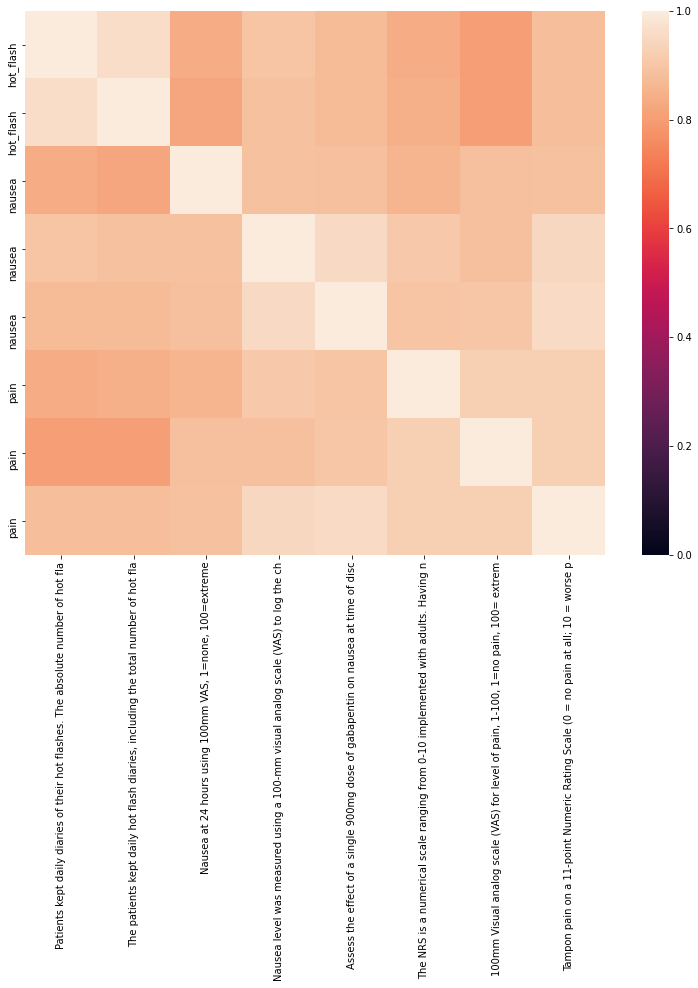

In [10]:
hot_flash_measures = [measures_w_desc.at[38, 'description']] + [measures_w_desc.at[41, 'description']]
nausea_measures = [measures_w_desc.at[53, 'description']] + [measures_w_desc.at[81, 'description']] + [measures_w_desc.at[132, 'description']]
pain_measures = [measures_w_desc.at[2, 'description']] + [measures_w_desc.at[51, 'description']] + [measures_w_desc.at[112, 'description']]
test_measures = hot_flash_measures + nausea_measures + pain_measures
test_measures_enc = model.encode(test_measures)

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(13,10))    
x_heatmap_labels = [x[:80] for x in test_measures]
y_heatmap_labels = ['hot_flash']*2 + ['nausea']*3 + ['pain']*3
sim_matrix = cosine_similarity(test_measures_enc)
ax = sns.heatmap(sim_matrix, xticklabels=x_heatmap_labels, yticklabels=y_heatmap_labels, vmax=1, vmin=0, ax=ax)

In [11]:
measure_desc_emb = model.encode(measures_studies['measure_description'].tolist())

In [ ]:
# We need to set up some new metrics like clustering 
# I want to make a 2D vis of all the drugs
from sklearn.cluster import AgglomerativeClustering


cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=.3).fit(measure_desc_emb)
measures_studies['cluster_label'] = pd.Series(cluster.labels_).values

In [ ]:
measures_studies['cluster_label'].value_counts()

0     1938
16    1300
4      925
1      641
6      373
13     333
23     302
12     199
7       50
5       30
43      28
10      22
41      21
40      21
19      21
2       16
3       14
9       14
14      12
38      12
11      11
44       9
32       8
20       6
18       6
29       5
21       5
26       5
8        4
25       3
30       3
31       3
15       3
34       3
28       3
27       2
36       2
22       2
17       2
42       2
33       1
24       1
45       1
39       1
37       1
35       1
Name: cluster_label, dtype: int64

### Viz
The plan: use t-SNE or other projection method to project the embeddings down, then color them by cluter, then overlay the most common treatments as words and see the map
- Note: maybe we should restrict studies to an FDA drug?? Come back to this

In [ ]:
# PCA projection first
# Need to scale the data 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

x = measure_desc_emb
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
pca.explained_variance_ratio_ # Jack shit varience ratio but a cool figure - certainly shows structure!

array([0.10606769, 0.07509401], dtype=float32)

In [ ]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
measures_studies['pc1'] = principalDf['principal component 1'].values
measures_studies['pc2'] = principalDf['principal component 2'].values

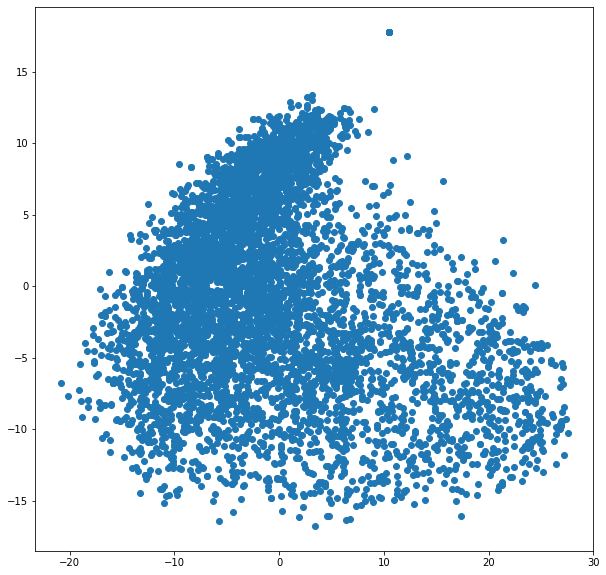

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
plt.scatter(measures_studies['pc1'], measures_studies['pc2'])
plt.show()


### t-SNE

In [ ]:
# Optional projection onto first 50 PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


x = measure_desc_emb
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=50)
principalComponents = pca.fit_transform(x)
x = principalComponents
x.shape

(6365, 50)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# uncomment to leave out PCA
# x = measure_desc_emb
# x = StandardScaler().fit_transform(x)

x_embedded = TSNE(n_components=2, perplexity=40, n_iter=2000).fit_transform(x)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


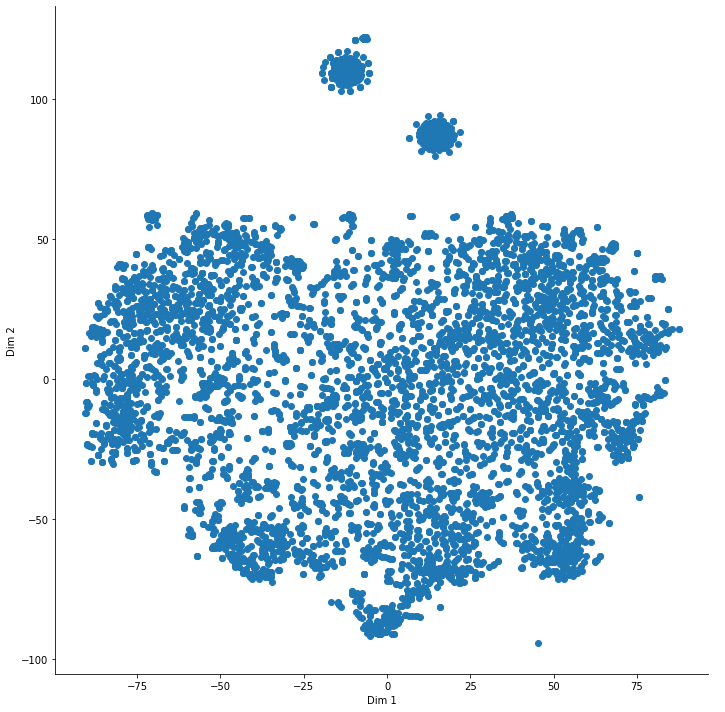

In [ ]:
import matplotlib.pyplot as plt

# Add in the cluster labels
tsne_df = pd.DataFrame(x_embedded).rename(columns={0: 'Dim 1', 1: 'Dim 2'})
# tsne_df['cluster'] = measures_studies['cluster_label']

sns.FacetGrid(tsne_df, size=10).map(plt.scatter, 'Dim 1', 'Dim 2').add_legend()
plt.show()

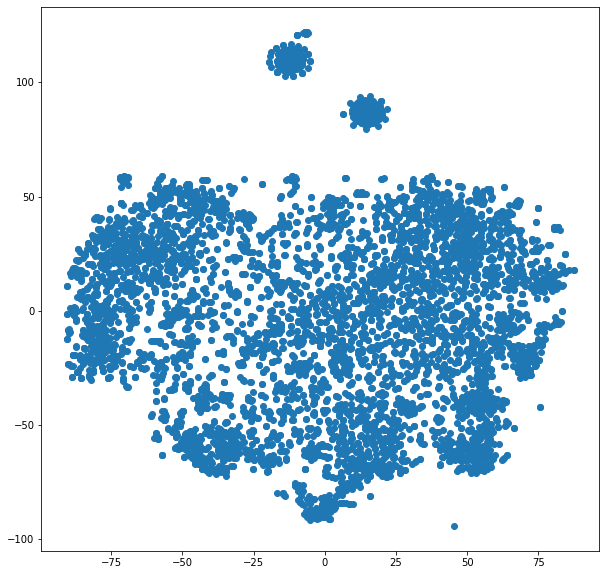

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10))
plt.scatter(x_embedded[:,0], x_embedded[:,1])
plt.show()


### Test Data
- Let's get a good set of measures that can be clustered - Gabapentin data + unrelated drug

In [ ]:
import pickle5 as pickle
gaba_measures = None
with open('drive/MyDrive/gaba_measures.pkl', "rb") as fh:
  gaba_measures = pickle.load(fh)

In [ ]:
# We need to set up some new metrics like clustering 
# I want to make a 2D vis of all the drugs
from sklearn.cluster import AgglomerativeClustering
measure_desc_emb = model.encode(gaba_measures['description'].tolist())


cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=.2).fit(measure_desc_emb)
gaba_measures['cluster_label'] = pd.Series(cluster.labels_).values

In [ ]:
# Optional projection onto first 50 PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

x = measure_desc_emb
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=50)
principalComponents = pca.fit_transform(x)
x = principalComponents
x.shape

x_embedded = TSNE(n_components=2, perplexity=20, n_iter=2000).fit_transform(x)

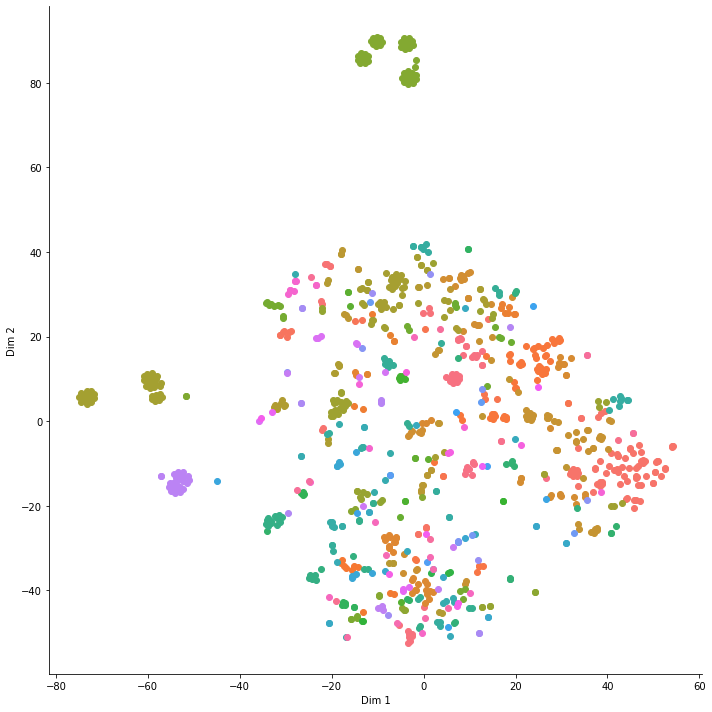

In [ ]:
import matplotlib.pyplot as plt

# Add in the cluster labels
tsne_df = pd.DataFrame(x_embedded).rename(columns={0: 'Dim 1', 1: 'Dim 2'})
tsne_df['cluster'] = gaba_measures['cluster_label']

sns.FacetGrid(tsne_df, hue='cluster', height=10).map(plt.scatter, 'Dim 1', 'Dim 2')
plt.show()

### Conditional Clustering
- What do these measures look like accross conditions, after all we are supposed to be detecting the symptom in the conditions

### E2E Condition Clustering and Render
We need to create a function that can evaluate the effectiveness of a cluster and see how it translates into a symptom

In [ ]:
exploded_measures = measures_studies.explode('conditions')
asthma_measures = exploded_measures[exploded_measures['conditions'] == 'Asthma']
asthma_measures = asthma_measures.drop_duplicates(['study_id', 'measure_description', 'measure_type'])

In [ ]:
import re
# A document is the combination of descriptions in a measurement cluster, it is a string
# Create the corpus
clusters = asthma_measures['cluster_label'].value_counts().keys().tolist()
doc_dict = {}
regex = re.compile('[^a-z A-Z]')
for cluster in clusters:
  descriptions = asthma_measures[asthma_measures['cluster_label'] == cluster]['measure_description'].tolist()
  document = ''.join([item for sublist in descriptions for item in sublist])
  doc_dict[cluster] = regex.sub('', document.lower());



In [ ]:
import re

# Actually I'm stupid we should obviously use tf-idf 
def create_corpus_freq(term, corpus): # number of documents that contain each word
  freq = {term: 0}
  for doc in corpus:
    if term in doc:
      freq[term] += 1
  return freq

def tfidf(term, document, corpus, corpus_fe):
  term_freq = sum([1 for x in document.split(' ') if x==term])
  idf = math.log(len(corpus)/(1+corpus_fe[term])) # Add one for divide by zero 
  return term_freq * idf

def create_tfidf(corpus): # Corpus is a dictionary of cluster:doc  
  # Unique terms
  doc_terms = {k: list(set(v.split(' '))) for k,v in corpus.items()}

  # Get tfidf for each term
  tf_idf = {}
  for cluster, terms in doc_terms.items():
    document = corpus[cluster]
    doc_vals = []
    for term in terms:
      corpus_freq = create_corpus_freq(term, corpus.values())
      term_tfidf = tfidf(term, document, doc_dict.values(), corpus_freq)
      doc_vals.append((term, term_tfidf))
    doc_vals.sort(reverse=True, key=lambda x: x[1])
    tf_idf[cluster] = doc_vals[:5]

  return tf_idf
  
tf_idf_asthma = create_tfidf(doc_dict)


In [ ]:
## Overall cluster vis 

# Optional projection onto first 50 PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


x = emb
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=50)
principalComponents = pca.fit_transform(x)
x = principalComponents
x.shape

# uncomment to leave out PCA
# x = measure_desc_emb
# x = StandardScaler().fit_transform(x)

x_embedded = TSNE(n_components=2, perplexity=15, n_iter=2000).fit_transform(x)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


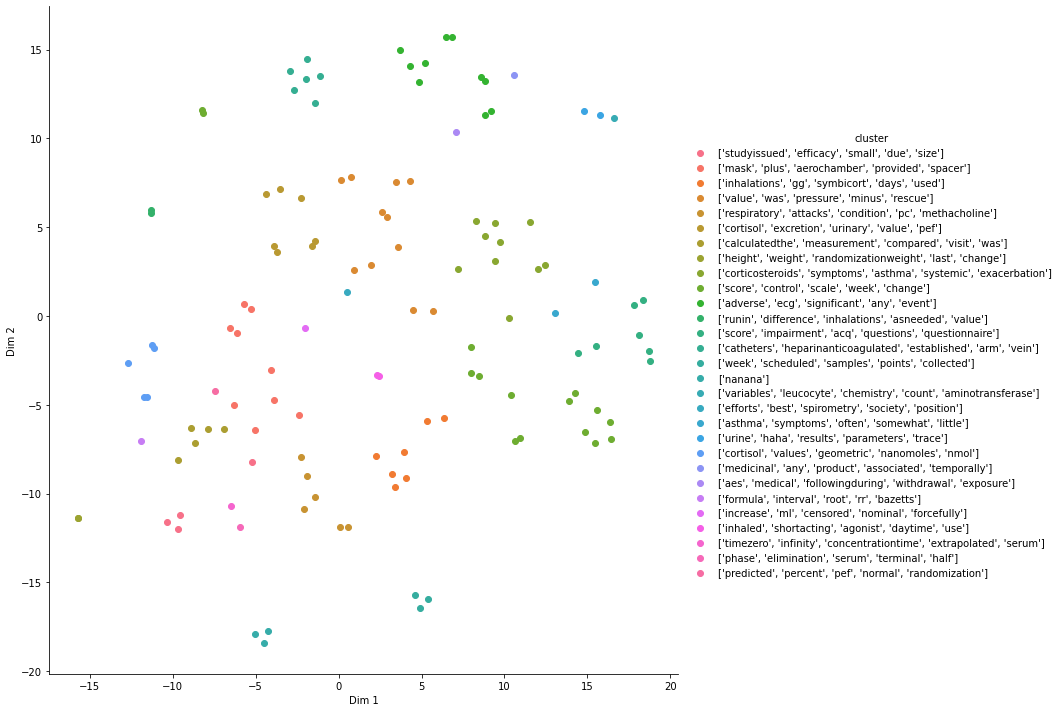

In [ ]:
import matplotlib.pyplot as plt

# Add in the cluster labels
tsne_df = pd.DataFrame(x_embedded).rename(columns={0: 'Dim 1', 1: 'Dim 2'})
tsne_df['cluster'] = asthma_measures['cluster_label'].values

labels = [x for x in tf_idf_asthma.items()]
labels.sort(key= lambda x: x[0])
labels = [x[1] for x in labels]
labels = [[y[0] for y in x] for x in labels]

sns.FacetGrid(tsne_df, hue='cluster', size=10).map(plt.scatter, 'Dim 1', 'Dim 2').add_legend(labels=labels)
plt.show()

## Clinical NER
- Training NER model
- Creating the vocab for the table


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', do_lower_case=True)

In [ ]:
tag2idx = {
    'B': 2,
    'I': 0,
    'O': 1,
    'PAD': 3
}

idx2tag = {v: k for k,v in tag2idx.items()}

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

# I'm dubious on the wrapper here we should maybe add our own linear layer
model = BertForTokenClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)
model.to(device)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

### Pretraining with NER Dataset

In [ ]:
from transformers import BertTokenizer, BertConfig
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

In [ ]:
MAX_LEN = 400
BATCH_SIZE = 22

In [ ]:
def read_tsv(fpath):
  with open(fpath) as f:
    lines = []
    words = []
    labels = []
    for line in f:
        line = line.strip()
        if len(line) == 0: #i.e. we're in between sentences
            assert len(words) == len(labels)
            if len(words) == 0:
                continue
            lines.append([words, labels])
            words = []
            labels = []
            continue
        
        word = line.split()[0]
        label = line.split()[-1]
        words.append(word)
        labels.append(label)

    #TODO: see if there's an off by one error here
    return lines


ch4_lines = read_tsv('drive/MyDrive/BC4CHEMD/train.tsv')

In [ ]:
def tokenize_and_preserve_labels(line_and_tags):
    tokenized_sentence = []
    labels = []

    for word, label in zip(line_and_tags[0], line_and_tags[1]):
      # Tokenize the word and count # of subwords the word is broken into
      tokenized_word = tokenizer.tokenize(word)
      n_subwords = len(tokenized_word)

      # Add the tokenized word to the final tokenized word list
      tokenized_sentence.extend(tokenized_word)

      # Add the same label to the new list of labels `n_subwords` times
      labels.extend([label] * n_subwords)

    return tokenized_sentence, labels
    
tokenized_texts_and_labels = [tokenize_and_preserve_labels(x) for x in ch4_lines]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
# Get the ids of the sequences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2021, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2021, test_size=0.1)

In [ ]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW

# I'm dubious on the wrapper here we should maybe add our own linear layer
model = BertForTokenClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)
model.to(device)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint 

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
def accuracy_score(y_true, y_pred):
  if any(isinstance(s, list) for s in y_true):
    y_true = [item for sublist in y_true for item in sublist]
    y_pred = [item for sublist in y_pred for item in sublist]

  nb_correct = sum(y_t == y_p for y_t, y_p in zip(y_true, y_pred))
  nb_true = len(y_true)

  score = nb_correct / nb_true

  return score

In [ ]:
from sklearn.metrics import f1_score
from tqdm import tqdm, trange

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [idx2tag[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if idx2tag[l_i] != "PAD"]
    valid_tags = [idx2tag[l_i] for l in true_labels
                                  for l_i in l if idx2tag[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags, average='micro')))
    print()



Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.01574410044965942
Validation loss: 0.04475706092385475




Epoch:  33%|███▎      | 1/3 [19:11<38:22, 1151.02s/it]

Validation Accuracy: 0.9876828580996643
Validation F1-Score: 0.9876828580996643

Average train loss: 0.011272298701059861
Validation loss: 0.04475706092385475




Epoch:  67%|██████▋   | 2/3 [38:21<19:10, 1150.84s/it]

Validation Accuracy: 0.9876828580996643
Validation F1-Score: 0.9876828580996643

Average train loss: 0.011448251089564255
Validation loss: 0.04475706092385475




Epoch: 100%|██████████| 3/3 [57:31<00:00, 1150.55s/it]

Validation Accuracy: 0.9876828580996643
Validation F1-Score: 0.9876828580996643



In [ ]:
torch.save(model.state_dict(), '/content/ClinicalBertNER.pt')

### Application of NER

In [ ]:
# Load the model
model.load_state_dict(torch.load('/content/drive/MyDrive/ClinicalBertNER.pt'))

<All keys matched successfully>

In [ ]:
def get_nes_from_string(string):
  tokenized_sentence = tokenizer.encode(string)
  input_ids = torch.tensor([tokenized_sentence]).to(device)
  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

  # Join the split tokens
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(idx2tag[label_idx])
          new_tokens.append(token)
  return new_tokens, new_labels


In [ ]:
hard_test = "Gabapentin/B-complex (Gavindo®) tablet administered orally at an initial dose of 300 milligram per day (mg/day) on Day 1, followed by 600 mg/day (one 300 milligram [mg] tablet every 12-hour) on Day 2, then 900 mg/day (one 300 mg tablet every 8-hour) on Day 7, then 1800 mg/day (two 300 mg tablets every 8-hour) on Day 21, then 2700 mg/day (three 300 mg tablets every 8-hour) on Day 35, and finally 3600 mg/day (four 300 mg tablets every 8-hour) on Days 56 and 84. Maximum dose allowed was 3600 mg/day. The total duration of treatment was 84 days (12 weeks)."

hard_test_tokens, hard_test_labels = get_nes_from_string(hard_test)
for token, label in zip(hard_test_tokens, hard_test_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
B	gabapentin
O	/
B	b
I	-
I	complex
O	(
B	gavindo®
O	)
O	tablet
O	administered
O	orally
O	at
O	an
O	initial
O	dose
O	of
O	300
O	milligram
O	per
O	day
O	(
O	mg
O	/
O	day
O	)
O	on
O	day
O	1
O	,
O	followed
O	by
O	600
O	mg
O	/
O	day
O	(
O	one
O	300
O	milligram
O	[
O	mg
O	]
O	tablet
O	every
O	12
O	-
O	hour
O	)
O	on
O	day
O	2
O	,
O	then
O	900
O	mg
O	/
O	day
O	(
O	one
O	300
O	mg
O	tablet
O	every
O	8
O	-
O	hour
O	)
O	on
O	day
O	7
O	,
O	then
O	1800
O	mg
O	/
O	day
O	(
O	two
O	300
O	mg
O	tablets
O	every
O	8
O	-
O	hour
O	)
O	on
O	day
O	21
O	,
O	then
O	2700
O	mg
O	/
O	day
O	(
O	three
O	300
O	mg
O	tablets
O	every
O	8
O	-
O	hour
O	)
O	on
O	day
O	35
O	,
O	and
O	finally
O	3600
O	mg
O	/
O	day
O	(
O	four
O	300
O	mg
O	tablets
O	every
O	8
O	-
O	hour
O	)
O	on
O	days
O	56
O	and
O	84
O	.
O	maximum
O	dose
O	allowed
O	was
O	3600
O	mg
O	/
O	day
O	.
O	the
O	total
O	duration
O	of
O	treatment
O	was
O	84
O	days
O	(
O	12
O	weeks
O	)
O	.
O	[SEP]


In [ ]:
# Vocab function 
from nltk.tokenize import word_tokenize, sent_tokenize

def tokenize_sentence(sent):
    sents = sent_tokenize(sent)
    hd_tokens = [word_tokenize(x.lower()) for x in sents]
    tokens = [item for sublist in hd_tokens for item in sublist]
    
    return tokens
  
def create_word_to_index(corpus):
  vocabulary = ['PAD']
  for sentence in corpus:
      for token in sentence:
          if token.lower() not in vocabulary:
              vocabulary.append(token.lower())

  word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
  idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}
  print("Number of unique vocab words in measures:", len(vocabulary))

  return word2idx, idx2word

In [ ]:
# Create measurement corpus and tokens
corpus = measures_studies['measure_description'].tolist()
corpus_tokens = [tokenize_sentence(sent) for sent in corpus]
word2idx, idx2word = create_word_to_index(corpus_tokens)

NameError: ignored

## All In System

### Runtime
- Enter condition
- Run clustering on condition
- Run P-vals on each cluster
- Return results 

### Post Processing
- Plot results 


### Pre Processing
- Add treatments to measurment groups 
- Connect stats table to measurement groups


In [ ]:
# Get all intervention studies
intervention_studies_1 = load_pickle5_file('/content/drive/MyDrive/intervention_studies_1.pkl')
intervention_studies_0 = load_pickle5_file('/content/drive/MyDrive/intervention_studies_0.pkl')
intervention_studies_2 = load_pickle5_file('/content/drive/MyDrive/intervention_studies_2.pkl')

intervention_studies = pd.concat([intervention_studies_1, intervention_studies_0, intervention_studies_2])

# Get all intervention measures
intervention_measures_1 = load_pickle5_file('/content/drive/MyDrive/int_measures_1.pkl')
intervention_measures_0 = load_pickle5_file('/content/drive/MyDrive/int_measures_0.pkl')
intervention_measures_2 = load_pickle5_file('/content/drive/MyDrive/int_measures_2.pkl')

intervention_measures = pd.concat([intervention_measures_1, intervention_measures_0, intervention_measures_2])

# Get all intervention outcomes
intervention_outcomes_1 = load_pickle5_file('/content/drive/MyDrive/int_outcomes_1.pkl')
intervention_outcomes_0 = load_pickle5_file('/content/drive/MyDrive/int_outcomes_0.pkl')
intervention_outcomes_2 = load_pickle5_file('/content/drive/MyDrive/int_outcomes_2.pkl')

intervention_outcomes = pd.concat([intervention_outcomes_1, intervention_outcomes_0, intervention_outcomes_2])

# Get all intervention admins
intervention_admins_1 = load_pickle5_file('/content/drive/MyDrive/int_admins_1.pkl')
intervention_admins_0 = load_pickle5_file('/content/drive/MyDrive/int_admins_0.pkl')
intervention_admins_2 = load_pickle5_file('/content/drive/MyDrive/int_admins_2.pkl')

intervention_admins = pd.concat([intervention_admins_1, intervention_admins_0, intervention_admins_2])


In [ ]:
# Let's make our stats rows
base = intervention_admins.merge(intervention_outcomes, 'outer', ['study_id', 'group_id', 'measure']).rename(columns={
    'title_x': 'group_title',
    'title_y': 'outcome_title'
})
base = base.merge(intervention_measures, 'left', ['study_id', 'measure']).drop_duplicates().rename(columns={
    'description_x': 'group_description',
    'description_y': 'measure_description'
})
base = base.fillna('NA')
base.head()

,study_id,group_id,measure,group_title,group_description,outcome_title,value,dispersion,upper,lower,participants,type,measure_description,dispersion_param,measure_param,units
0,NCT00262834,OG000,Number of Participants With Adverse Events,Vorinostat,Women in the vorinostat group were scheduled t...,NA,17,NA,NA,NA,25,Primary,Participants were evaluated for adverse events...,NA,Number,participants
1,NCT00262834,OG000,Change in Tissue Proliferation After 3 Days of...,Vorinostat,Women in the vorinostat group were scheduled t...,NA,-3,NA,38,-62,25,Primary,Change in Ki-67 (a marker of tissue proliferat...,Full Range,Mean,percentage of change
2,NCT00262834,OG001,Change in Tissue Proliferation After 3 Days of...,Tissue Only,Women who declined vorinostat but agreed to do...,NA,-4,NA,46,-32,29,Primary,Change in Ki-67 (a marker of tissue proliferat...,Full Range,Mean,percentage of change
3,NCT00262834,OG000,Change in Tissue Apoptosis After 3 Days of Tre...,Vorinostat,Women in the vorinostat group were scheduled t...,NA,0,NA,5,-5,25,Primary,Change in cleaved caspase-3 (a marker of tissu...,Full Range,Mean,percentage of change
4,NCT00262834,OG001,Change in Tissue Apoptosis After 3 Days of Tre...,Tissue Only,Women who declined vorinostat but agreed to do...,NA,0,NA,3,-2,29,Primary,Change in cleaved caspase-3 (a marker of tissu...,Full Range,Mean,percentage of change


In [ ]:
import scipy.stats as stats
import math

def get_sd(outcome_spread, ranges, value, no_obs):
    try:
        if outcome_spread == 'Standard Error':
            return math.sqrt(no_obs) * float(ranges) # assuming ranges is one number in this case

        if outcome_spread == '95% Confidence Interval':
            return math.sqrt(int(no_obs)) * (float(ranges[1]) - float(ranges[0])) / 3.92

        if outcome_spread == 'Standard Deviation':
            if isinstance(ranges, tuple):
                return -2
            return float(ranges)

        if outcome_spread == "Inter-Quartile Range":
            return (float(ranges[1]) - float(ranges[0])) / 1.35 # Assuming the distribution is normal 
        
    except ValueError as e: # A little too catch-all imo, this whole system needs to be reworked
        return -1
    
    return -1

def get_ranges(row):
  if row.dispersion_param in ['Inter-Quartile Range', '95% Confidence Interval']:
    return (row.lower, row.upper)
  
  return row.dispersion


def get_pval(row_a, row_b):
    mean1 = float(row_a.value.replace(',','')) if row_a.value != 'NA' else -1
    ranges1 = get_ranges(row_a)
    nobs1 = int(row_a.participants.replace(',','')) if row_a.participants != 'NA' else -1
    
    mean2 = float(row_b.value.replace(',','')) if row_b.value != 'NA' else -1
    ranges2 = get_ranges(row_b)
    nobs2 = int(row_b.participants.replace(',','')) if row_b.participants != 'NA' else -1
    
    if (-1 in {mean1, nobs1, mean2, nobs2}):
        return -1

    if nobs1+nobs2 <= 2:
        return -1

    std2 = get_sd(row_a.dispersion_param, ranges2, mean2, nobs2)
    std1 = get_sd(row_a.dispersion_param, ranges1, mean1, nobs1)
    
    if (-2 in {std1, std2}):
        return -1
    
    if (-1 in {std1, std2}):
        return -1
    
    p_val = stats.ttest_ind_from_stats(mean1=mean1, std1=std1, nobs1=nobs1,mean2=mean2, std2=std2, nobs2=nobs2).pvalue
    
    return float(p_val)

In [ ]:
# We need to create a seperate table to hold the comparisons between the different groups
# We should make entries into the existing analytics table
from tqdm import tqdm

new_analysis = {
    'study_id': [],
    'measure': [],
    'groups': [],
    'description': [],
    'method': [],
    'param_type': [],
    'fromStudy': [],
    'pval': [],
    'group_titles': []
}

study_ids = intervention_studies['study_id'].tolist()
for study_id in study_ids:
    # Select all measures with that study
    base_group = base[base['study_id']==study_id]
    measures = list(base_group['measure'].value_counts().keys())
    
    for measure in measures:
        measure_group = base_group[base_group['measure'] == measure]
        outcome_titles = list(measure_group['outcome_title'].value_counts().keys()) # Need to fill in the NaNs before
        for outcome_title in outcome_titles:
            outcome_group = measure_group[measure_group['outcome_title'] == outcome_title]
            groups = list(outcome_group['group_id'].value_counts().keys())
            for i in range(len(groups)):
                for j in range(len(groups)):
                    if i<=j:
                        continue

                    group_a = groups[i]
                    group_b = groups[j]
                    
                    row_a = outcome_group[outcome_group['group_id'] == group_a].iloc[0] # This should be one single row
                    row_b = outcome_group[outcome_group['group_id'] == group_b].iloc[0]
                    pval = get_pval(row_a, row_b)
                    
                    new_analysis['study_id'].append(study_id)
                    new_analysis['measure'].append(measure)
                    new_analysis['groups'].append([group_a, group_b])
                    new_analysis['description'].append(outcome_title)
                    new_analysis['method'].append('t-test')
                    new_analysis['param_type'].append('?')
                    new_analysis['fromStudy'].append(False)
                    new_analysis['pval'].append(pval)
                    new_analysis['group_titles'].append({group_a: row_a['group_title'], group_b: row_b['group_title']})


KeyboardInterrupt: ignored

In [ ]:
curr_stats = pd.DataFrame.from_dict(new_analysis)
curr_stats.to_pickle('int_stats.pkl')
from google.colab import files
files.download("/content/int_stats.pkl")

In [ ]:
def get_nes_from_string(string, model):
  tokenized_sentence = tokenizer.encode(string)
  input_ids = torch.tensor([tokenized_sentence]).to(device)
  with torch.no_grad():
    output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])

  # Join the split tokens
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(idx2tag[label_idx])
          new_tokens.append(token)
  return new_tokens, new_labels

In [ ]:
def get_unique_treatments(string, model):
  tokens, labels = get_nes_from_string(string, model)
  treatments = []
  for i in range(len(tokens)):
    token = tokens[i]
    label = labels[i]
    if label == 'B':
      treatments.append(token)
    if label == 'I' and treatments:
      treatments[-1] += token
  
  return list(set(treatments))


In [ ]:
# Add treatments
# Need to batch this, but let's take a small percentage for now
model.eval()
int_admins_sample = intervention_admins
int_admins_sample['desc_plus_title'] = int_admins_sample['title'] + ' ' + int_admins_sample['description']
int_admins_sample['desc_plus_title'] = int_admins_sample['desc_plus_title']
treatments = []
for row in int_admins_sample['desc_plus_title']:
  try:
    treatments.append(get_unique_treatments(row, model))
    if len(treatments) % 10000 == 0:
      print(len(treatments))
  except Exception as e:
    treatments.append('NA')
    print(e)
    continue

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
The size of tensor a (611) must match the size of tensor b (512) at non-singleton dimension 1
The size of tensor a (611) must match the size of tensor b (512) at non-singleton dimension 1
The size of tensor a (611) must match the size of tensor b (512) at non-singleton dimension 1
The size of tensor a (611) must match the size of tensor b (512) at non-singleton dimension 1
The size of tensor a (611) must match the size of tensor b (512) at non-singleton dimension 1
The size of tensor a (611) must match the size of tensor b (512) at non-singleton dimension 1
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
The size of tensor a (566) must match the size of tensor b (512) at non-singleton dimension 1
The size of tensor a (673) must match the size of tensor b (512) at non-singleton dimension 1
The s

In [5]:
int_admins_sample = load_pickle5_file('/content/drive/MyDrive/int_admins_sample.pkl')

In [6]:
# Apply the rules filter - removing treatments based on titles
int_admins_sample['title_treats'] = [[z for z in y if z in x.lower()] for x,y in zip(int_admins_sample['title'], int_admins_sample['treatments'])]
title_treats_df = int_admins_sample.groupby('study_id')['title_treats'].apply(list).reset_index()
title_treats_df['title_treats_flat'] = [list(set([item for sublist in x for item in sublist])) for x in title_treats_df['title_treats']]
with_title_treats = int_admins_sample.merge(title_treats_df[['study_id', 'title_treats_flat']], 'inner', ['study_id'])
with_title_treats['subtracted'] = [[z for z in x if z not in y] for x,y in zip(with_title_treats['treatments'], with_title_treats['title_treats_flat'])]
with_title_treats['added'] = with_title_treats['subtracted'] + with_title_treats['title_treats']
adjusted_int_admins = with_title_treats.drop(columns=['title_treats', 'title_treats_flat', 'subtracted']).rename(columns={'added':'adjusted'})
adjusted_int_admins = adjusted_int_admins.drop_duplicates(['study_id', 'group_id', 'measure'])
adjusted_int_admins.head()

,study_id,group_id,measure,title,description,desc_plus_title,treatments,adjusted
0,NCT00262834,OG000,Number of Participants With Adverse Events,Vorinostat,Women in the vorinostat group were scheduled t...,Vorinostat Women in the vorinostat group were ...,[vorinostat],[vorinostat]
1,NCT00262834,OG000,Change in Tissue Proliferation After 3 Days of...,Vorinostat,Women in the vorinostat group were scheduled t...,Vorinostat Women in the vorinostat group were ...,[vorinostat],[vorinostat]
2,NCT00262834,OG001,Change in Tissue Proliferation After 3 Days of...,Tissue Only,Women who declined vorinostat but agreed to do...,Tissue Only Women who declined vorinostat but ...,[vorinostat],[]
3,NCT00262834,OG000,Change in Tissue Apoptosis After 3 Days of Tre...,Vorinostat,Women in the vorinostat group were scheduled t...,Vorinostat Women in the vorinostat group were ...,[vorinostat],[vorinostat]
4,NCT00262834,OG001,Change in Tissue Apoptosis After 3 Days of Tre...,Tissue Only,Women who declined vorinostat but agreed to do...,Tissue Only Women who declined vorinostat but ...,[vorinostat],[]


In [8]:
adjusted_int_admins

,study_id,group_id,measure,title,description,desc_plus_title,treatments,adjusted
0,NCT00262834,OG000,Number of Participants With Adverse Events,Vorinostat,Women in the vorinostat group were scheduled t...,Vorinostat Women in the vorinostat group were ...,[vorinostat],[vorinostat]
1,NCT00262834,OG000,Change in Tissue Proliferation After 3 Days of...,Vorinostat,Women in the vorinostat group were scheduled t...,Vorinostat Women in the vorinostat group were ...,[vorinostat],[vorinostat]
2,NCT00262834,OG001,Change in Tissue Proliferation After 3 Days of...,Tissue Only,Women who declined vorinostat but agreed to do...,Tissue Only Women who declined vorinostat but ...,[vorinostat],[]
3,NCT00262834,OG000,Change in Tissue Apoptosis After 3 Days of Tre...,Vorinostat,Women in the vorinostat group were scheduled t...,Vorinostat Women in the vorinostat group were ...,[vorinostat],[vorinostat]
4,NCT00262834,OG001,Change in Tissue Apoptosis After 3 Days of Tre...,Tissue Only,Women who declined vorinostat but agreed to do...,Tissue Only Women who declined vorinostat but ...,[vorinostat],[]
...,...,...,...,...,...,...,...,...
540083,NCT03031496,OG001,Respiratory Rate Values at Indicated Time Points,Treatment B,Participants received a single oral dose of hy...,Treatment B Participants received a single ora...,"[amiloridehydrochloride, hydrochlorothiazide]","[amiloridehydrochloride, hydrochlorothiazide]"
540084,NCT03031496,OG000,Pulse Rate Values at Indicated Time Points,Treatment A,Participants received a single oral dose of hy...,Treatment A Participants received a single ora...,"[amiloridehydrochloride, hydrochlorothiazide]","[amiloridehydrochloride, hydrochlorothiazide]"
540085,NCT03031496,OG001,Pulse Rate Values at Indicated Time Points,Treatment B,Participants received a single oral dose of hy...,Treatment B Participants received a single ora...,"[amiloridehydrochloride, hydrochlorothiazide]","[amiloridehydrochloride, hydrochlorothiazide]"
540086,NCT03031496,OG000,Body Temperature Values at Indicated Time Points,Treatment A,Participants received a single oral dose of hy...,Treatment A Participants received a single ora...,"[amiloridehydrochloride, hydrochlorothiazide]","[amiloridehydrochloride, hydrochlorothiazide]"


In [7]:
adjusted_int_admins[adjusted_int_admins['treatments'] != adjusted_int_admins['adjusted']]

,study_id,group_id,measure,title,description,desc_plus_title,treatments,adjusted
2,NCT00262834,OG001,Change in Tissue Proliferation After 3 Days of...,Tissue Only,Women who declined vorinostat but agreed to do...,Tissue Only Women who declined vorinostat but ...,[vorinostat],[]
4,NCT00262834,OG001,Change in Tissue Apoptosis After 3 Days of Tre...,Tissue Only,Women who declined vorinostat but agreed to do...,Tissue Only Women who declined vorinostat but ...,[vorinostat],[]
5,NCT00262834,OG000,Change in Tissue Histone Acetylation After 3 D...,Arm I,Patients receive oral vorinostat twice daily o...,Arm I Patients receive oral vorinostat twice d...,[vorinostat],[]
7,NCT00262834,OG001,Change in Blood (Peripheral Blood Mononuclear ...,Tissue Only,Women who declined vorinostat but agreed to do...,Tissue Only Women who declined vorinostat but ...,[vorinostat],[]
47,NCT00265083,OG000,Assessment in Ankylosing Spondylitis 20 Respon...,Group I: Placebo,Placebo SC injections every 4 weeks (wks) from...,Group I: Placebo Placebo SC injections every 4...,[golimumab],[]
...,...,...,...,...,...,...,...,...
539928,NCT03039192,OG000,Number of Participants With Treatment Emergent...,Placebo Plus SOC Antidepressant Treatment,Participants self-administered placebo matched...,Placebo Plus SOC Antidepressant Treatment Part...,[esketamine],[]
539930,NCT03039192,OG000,Number of Participants With Abnormal Arterial ...,Placebo Plus SOC Antidepressant Treatment,Participants self-administered placebo matched...,Placebo Plus SOC Antidepressant Treatment Part...,[esketamine],[]
539932,NCT03039192,OG000,Number of Participants With Treatment Emergent...,Placebo Plus SOC Antidepressant Treatment,Participants self-administered placebo matched...,Placebo Plus SOC Antidepressant Treatment Part...,[esketamine],[]
539934,NCT03039192,OG000,Number of Sedated Participants as Assessed by ...,Placebo Plus SOC Antidepressant Treatment,Participants self-administered placebo matched...,Placebo Plus SOC Antidepressant Treatment Part...,[esketamine],[]


In [ ]:
# Load the stats
int_analytics = load_pickle5_file('/content/drive/MyDrive/int_analytics.pkl')

In [ ]:
intervention_studies

,study_id,name,drug,conditions,verified_date,responsible_party,type,description,interventions,purpose,intervention_type,mesh_terms
0,NCT00262834,A Pilot Study Evaluating Surrogates of Respons...,NA,"[Breast Cancer, Stage I Breast Cancer, Stage I...",February 2020,{'ResponsiblePartyType': 'Sponsor'},Interventional,PRIMARY OBJECTIVE:\n\nI. Determine the safety ...,[Vorinostat],Treatment,Single Group Assignment,[Breast Neoplasms]
1,NCT00262639,A Double Blind Evaluation of Flumazenil and Ga...,NA,[Alcohol Dependence],February 2019,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,Approximately 60 alcohol dependent individuals...,"[Gabapentin, Flumazenil]",Treatment,Parallel Assignment,[Alcoholism]
2,NCT00266695,Open-Label Treatment for Patients Completing S...,NA,[Diabetic Retinopathy],August 2016,{'ResponsiblePartyType': 'Sponsor'},Interventional,NA,[Ruboxistaurin],Treatment,Single Group Assignment,[Diabetic Retinopathy]
3,NCT00262951,A Phase II Pilot Study of Multi-Agent Neo-Adju...,NA,[Pancreatic Cancer],December 2017,{'ResponsiblePartyType': 'Sponsor'},Interventional,OBJECTIVES:\n\nPrimary\n\nDetermine the effect...,"[Interferons, Interferon-alpha, Interferon alp...",Treatment,Single Group Assignment,[Pancreatic Neoplasms]
4,NCT00266656,Effect of Early Growth Hormone Treatment on Lo...,NA,[Turner Syndrome],March 2017,{'ResponsiblePartyType': 'Sponsor'},Interventional,NA,[Hormones],Treatment,Parallel Assignment,"[Turner Syndrome, Gonadal Dysgenesis, Syndrome]"
...,...,...,...,...,...,...,...,...,...,...,...,...
8090,NCT03035708,Human Laboratory Study of Varenicline for Alco...,NA,[Alcohol Use Disorder],October 2019,{'ResponsiblePartyType': 'Sponsor'},Interventional,"This study is a double-blind, randomized, plac...",[Varenicline],Treatment,Parallel Assignment,"[Alcoholism, Alcohol Drinking]"
8091,NCT03034772,A Randomized Controlled Trial Comparing the Ef...,NA,"[Neovascular Age-related Macular Degeneration,...",June 2020,{'ResponsiblePartyType': 'Principal Investigat...,Interventional,Intravitreal anti-vascular endothelial growth ...,"[Timolol, Dorzolamide, Lubricant Eye Drops]",Treatment,Parallel Assignment,"[Macular Degeneration, Wet Macular Degeneration]"
8092,NCT03030989,A Double-blind Randomized Placebo Controlled C...,NA,[Stem Cell Transplant Complications],November 2020,{'ResponsiblePartyType': 'Sponsor'},Interventional,NA,"[Chlorhexidine, Chlorhexidine gluconate]",Prevention,Parallel Assignment,[Infection]
8093,NCT03038880,STAIRWAY: Simultaneous Blockade of Angiopoieti...,NA,"[Neovascularization, Choroidal, Macular Degene...",December 2020,{'ResponsiblePartyType': 'Sponsor'},Interventional,NA,[Ranibizumab],Treatment,Parallel Assignment,"[Macular Degeneration, Choroidal Neovasculariz..."


In [ ]:
int_analytics['group_a'] = [x[0] for x in int_analytics['groups']]
int_analytics['group_b'] = [x[1] for x in int_analytics['groups']]

int_analytics_merge_1 = int_analytics.rename(columns={
    'group_a': 'group_id'
}).merge(adjusted_int_admins[['study_id', 'group_id', 'measure', 'adjusted' ]], 'inner', ['study_id', 'group_id', 'measure'])
int_analytics_merge_2 = int_analytics_merge_1.rename(columns={
    'group_id': 'group_a',
    'group_b': 'group_id'
}).merge(adjusted_int_admins[['study_id', 'group_id', 'measure', 'adjusted' ]], 'inner', ['study_id', 'group_id', 'measure']).rename(columns={
    'group_id': 'group_b',
    'adjusted_x': 'treatments_a',
    'adjusted_y': 'treatments_b'
})
analytics_rows = int_analytics_merge_2.merge(intervention_measures[['study_id', 'measure','description']].drop_duplicates(['study_id', 'measure']), 
                                             'inner', 
                                             ['study_id', 'measure']).rename(columns={
                                                 'description_y': 'measure_description',
                                                 'description_x': 'admin_description'
                                             })
analytics_rows = analytics_rows.merge(intervention_studies[['study_id', 'conditions']], 'inner', ['study_id'])
int_analytics_merge_1 = None
int_analytics_merge_2 = None

analytics_rows.head()

,study_id,measure,groups,admin_description,method,param_type,fromStudy,pval,group_titles,group_a,group_b,treatments_a,treatments_b,measure_description
0,NCT00262834,Change in Tissue Apoptosis After 3 Days of Tre...,"[OG000, OG001]",NA,t-test,?,False,-1.0,"{'OG000': 'Vorinostat', 'OG001': 'Tissue Only'}",OG000,OG001,[vorinostat],[],Change in cleaved caspase-3 (a marker of tissu...
1,NCT00262834,Change in Tissue Proliferation After 3 Days of...,"[OG000, OG001]",NA,t-test,?,False,-1.0,"{'OG000': 'Vorinostat', 'OG001': 'Tissue Only'}",OG000,OG001,[vorinostat],[],Change in Ki-67 (a marker of tissue proliferat...
2,NCT00262834,Change in Blood (Peripheral Blood Mononuclear ...,"[OG000, OG001]",NA,t-test,?,False,-1.0,"{'OG000': 'Vorinostat', 'OG001': 'Tissue Only'}",OG000,OG001,[vorinostat],[],To evaluate baseline and change in histone ace...
3,NCT00262639,Percent Subjects Completely Abstinent,"[OG001, OG003]",NA,t-test,?,False,-1.0,"{'OG001': 'Low CIWAar Placebo', 'OG003': 'High...",OG001,OG003,[],"[flumazenil, gabapentin]",percent of subjects completely abstinent durin...
4,NCT00262639,Percent Subjects Completely Abstinent,"[OG000, OG003]",NA,t-test,?,False,-1.0,"{'OG000': 'Low CIWA Flumazenil/Gabapentin', 'O...",OG000,OG003,"[flumazenil, gabapentin]","[flumazenil, gabapentin]",percent of subjects completely abstinent durin...


In [ ]:
# Add in the "diff_treatments" column for convenience 
# Also adding "solo_treatment" column for convenience
analytics_rows["diff_treatments"] = [list(set(x).symmetric_difference(set(y))) for x,y in zip(analytics_rows['treatments_a'], analytics_rows['treatments_b'])]
analytics_rows["solo_treatment"] = (analytics_rows['treatments_a'].apply(len) == 0) | (analytics_rows['treatments_b'].apply(len) == 0)


In [ ]:
analytics_rows.to_pickle('intervention_analytics.pkl')

## Runtime
Given a condition, we look at the analytics, cluster the measures and parse out recomendations
- Select rows containing the condition
- Run clustering on the measurements
- Select solo_treatment results and aggregate them by treatment (somehow)
- Select non solo_treatment results and aggregate them (somehow)

Aggregation can just be a raw average although it should definitely be weighted

In [17]:
analytics_rows = load_pickle5_file('/content/drive/MyDrive/intervention_analytics.pkl')

In [18]:
working_rows = analytics_rows[(analytics_rows['pval'] > -1) & (analytics_rows['diff_treatments'].apply(len) != 0)]

In [19]:
working_rows.head()

,study_id,measure,groups,admin_description,method,param_type,fromStudy,pval,group_titles,group_a,group_b,treatments_a,treatments_b,measure_description,conditions,diff_treatments,solo_treatment
9,NCT00262639,Percent Days Abstinent,"[OG001, OG003]",NA,t-test,?,False,0.236682,"{'OG001': 'Low CIWAar Placebo', 'OG003': 'High...",OG001,OG003,[],"[flumazenil, gabapentin]",percent days abstinent during treatment,[Alcohol Dependence],"[flumazenil, gabapentin]",True
11,NCT00262639,Percent Days Abstinent,"[OG002, OG003]",NA,t-test,?,False,0.084525,"{'OG002': 'High CIWAar Placebo', 'OG003': 'Hig...",OG002,OG003,[],"[flumazenil, gabapentin]",percent days abstinent during treatment,[Alcohol Dependence],"[flumazenil, gabapentin]",True
12,NCT00262639,Percent Days Abstinent,"[OG000, OG001]",NA,t-test,?,False,0.029790,"{'OG000': 'Low CIWA Flumazenil/Gabapentin', 'O...",OG000,OG001,"[flumazenil, gabapentin]",[],percent days abstinent during treatment,[Alcohol Dependence],"[flumazenil, gabapentin]",True
14,NCT00262639,Percent Days Abstinent,"[OG002, OG000]",NA,t-test,?,False,0.623454,"{'OG002': 'High CIWAar Placebo', 'OG000': 'Low...",OG002,OG000,[],"[flumazenil, gabapentin]",percent days abstinent during treatment,[Alcohol Dependence],"[flumazenil, gabapentin]",True
107,NCT00267293,Child Temperature (Degrees C)Over 6 Hours,"[OG000, OG002]",NA,t-test,?,False,0.000036,"{'OG000': 'Group A: Ibuprofen Alone', 'OG002':...",OG000,OG002,[ibuprofen],"[acetaminophen, ibuprofen]",Temperature was measured hourly using a tempor...,[Fever],[acetaminophen],False


In [20]:
searchable_conditions = working_rows.explode('conditions')['conditions'].value_counts()

In [21]:
searchable_conditions

Arthritis, Rheumatoid                     27625
Rheumatoid Arthritis                      20249
Asthma                                    17181
Diabetes Mellitus, Type 2                 16755
Type 2 Diabetes Mellitus                  13122
                                          ...  
Pediatric Pateints                            1
Autosomal Recessive Agammaglobulinemia        1
Opioid Detoxification                         1
Social Intelligence                           1
Phenytoin Toxicity                            1
Name: conditions, Length: 5668, dtype: int64

In [22]:
# based off the above let's try asthma
EXAMPLE_CONDITION='Asthma'

In [23]:
asthma_rows = working_rows[working_rows['conditions'].apply(lambda x: EXAMPLE_CONDITION in x)]

In [24]:
asthma_rows['measure_title_desc'] = asthma_rows['measure'] + ' ' + asthma_rows['measure_description']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
# Cluster the measures
# uniques
from sklearn.cluster import AgglomerativeClustering

unique_measures = pd.DataFrame(asthma_rows['measure_title_desc'].value_counts().keys()).rename(columns={0:'measure_title_desc'})
measure_desc_emb = model.encode(unique_measures['measure_title_desc'])

cluster = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=.2).fit(measure_desc_emb)
unique_measures['cluster_label'] = pd.Series(cluster.labels_).values

In [27]:
# Merge with other
asthma_rows_clustered = asthma_rows.merge(unique_measures, 'inner', ['measure_title_desc'])

In [28]:
# We need to try this with averging the pvals in a single measure/group duos i.e. average them if done over time

In [29]:
import math
# Aggregate!!
# Let's just do it iteratively for now
clusters = unique_measures['cluster_label'].value_counts().keys()

cluster_to_treatment_scores = {}
for cluster in clusters:
  cluster_to_treatment_scores[cluster] = {}
  cluster_rows = asthma_rows_clustered[asthma_rows_clustered['cluster_label'] == cluster]
  treatments = list(cluster_rows.explode('diff_treatments')['diff_treatments'].value_counts().keys())
  for treatment in treatments:
    solo_avg = cluster_rows[(cluster_rows['diff_treatments'].apply(len) == 1) & (cluster_rows['diff_treatments'].apply(lambda x: treatment in x))]['pval'].mean()
    if not math.isnan(solo_avg):
      cluster_to_treatment_scores[cluster][treatment] = solo_avg


In [30]:
asthma_rows_clustered[asthma_rows_clustered['cluster_label'] == 1]

,study_id,measure,groups,admin_description,method,param_type,fromStudy,pval,group_titles,group_a,group_b,treatments_a,treatments_b,measure_description,conditions,diff_treatments,solo_treatment,measure_title_desc,cluster_label
1133,NCT01402986,Mean Change From Baseline in Peak Expiratory F...,"[OG000, OG002]","Change at Day 365-371: Morning (n=124,119,114)",t-test,?,False,0.944950,"{'OG000': 'Placebo Total', 'OG002': 'Tralokinu...",OG000,OG002,[],[tralokinumab],The PEF is a participant's maximum speed of ex...,[Asthma],[tralokinumab],True,Mean Change From Baseline in Peak Expiratory F...,1
1134,NCT01402986,Mean Change From Baseline in Peak Expiratory F...,"[OG000, OG002]","Change at Day 365-371: Evening (n=120,116,112)",t-test,?,False,0.105362,"{'OG000': 'Placebo Total', 'OG002': 'Tralokinu...",OG000,OG002,[],[tralokinumab],The PEF is a participant's maximum speed of ex...,[Asthma],[tralokinumab],True,Mean Change From Baseline in Peak Expiratory F...,1
1135,NCT01402986,Mean Change From Baseline in Peak Expiratory F...,"[OG000, OG002]","Day 1-7: Morning (n=151,149,149)",t-test,?,False,0.569738,"{'OG000': 'Placebo Total', 'OG002': 'Tralokinu...",OG000,OG002,[],[tralokinumab],The PEF is a participant's maximum speed of ex...,[Asthma],[tralokinumab],True,Mean Change From Baseline in Peak Expiratory F...,1
1136,NCT01402986,Mean Change From Baseline in Peak Expiratory F...,"[OG000, OG002]","Day 1-7: Evening (n=149,147,148)",t-test,?,False,0.560561,"{'OG000': 'Placebo Total', 'OG002': 'Tralokinu...",OG000,OG002,[],[tralokinumab],The PEF is a participant's maximum speed of ex...,[Asthma],[tralokinumab],True,Mean Change From Baseline in Peak Expiratory F...,1
1137,NCT01402986,Mean Change From Baseline in Peak Expiratory F...,"[OG000, OG001]","Change at Day 365-371: Morning (n=124,119,114)",t-test,?,False,0.202806,"{'OG000': 'Placebo Total', 'OG001': 'Tralokinu...",OG000,OG001,[],[tralokinumab],The PEF is a participant's maximum speed of ex...,[Asthma],[tralokinumab],True,Mean Change From Baseline in Peak Expiratory F...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13282,NCT00768079,Peak Expiratory Flow (PEF) Recorded at Home,"[OG000, OG001]",Day 43 to 49,t-test,?,False,0.316316,"{'OG000': 'Placebo', 'OG001': 'Benralizumab 0....",OG000,OG001,[medi563],"[medi-563, benralizumab]",The PEF is a participant's maximum speed of ex...,[Asthma],"[benralizumab, medi-563, medi563]",False,Peak Expiratory Flow (PEF) Recorded at Home Th...,1
13283,NCT00768079,Peak Expiratory Flow (PEF) Recorded at Home,"[OG000, OG001]",Day 57 to 63,t-test,?,False,0.643673,"{'OG000': 'Placebo', 'OG001': 'Benralizumab 0....",OG000,OG001,[medi563],"[medi-563, benralizumab]",The PEF is a participant's maximum speed of ex...,[Asthma],"[benralizumab, medi-563, medi563]",False,Peak Expiratory Flow (PEF) Recorded at Home Th...,1
13284,NCT00768079,Peak Expiratory Flow (PEF) Recorded at Home,"[OG000, OG001]",Day 64 to 70,t-test,?,False,0.152260,"{'OG000': 'Placebo', 'OG001': 'Benralizumab 0....",OG000,OG001,[medi563],"[medi-563, benralizumab]",The PEF is a participant's maximum speed of ex...,[Asthma],"[benralizumab, medi-563, medi563]",False,Peak Expiratory Flow (PEF) Recorded at Home Th...,1
13285,NCT00768079,Peak Expiratory Flow (PEF) Recorded at Home,"[OG000, OG001]",Day 8 to 14,t-test,?,False,0.396880,"{'OG000': 'Placebo', 'OG001': 'Benralizumab 0....",OG000,OG001,[medi563],"[medi-563, benralizumab]",The PEF is a participant's maximum speed of ex...,[Asthma],"[benralizumab, medi-563, medi563]",False,Peak Expiratory Flow (PEF) Recorded at Home Th...,1


In [31]:
# Try this: get the top X clusters by "size" (try different sizes) and put them on the TSNE with the top Y treatments
# We can include a text table beside it in the presentation
# We can also shwo how it all changes when the min_distance is changed in the agglomerative mechanism

In [32]:
# First go with no_studies
clusters_by_studies = asthma_rows_clustered.groupby('cluster_label')['study_id'].nunique().reset_index().sort_values('study_id', ascending=False)
clusters_sorted = list(clusters_by_studies['cluster_label'][:10])
top_asthma_measures = asthma_rows_clustered[asthma_rows_clustered['cluster_label'].isin(clusters_sorted)][['measure_title_desc', 'cluster_label']].drop_duplicates()

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

measure_enc = model.encode(top_asthma_measures['measure_title_desc'].tolist())
x = StandardScaler().fit_transform(measure_enc)

pca = PCA(n_components=50)
principalComponents = pca.fit_transform(x)
x = principalComponents
x.shape

x_embedded = TSNE(n_components=2, perplexity=20, n_iter=2000).fit_transform(x)

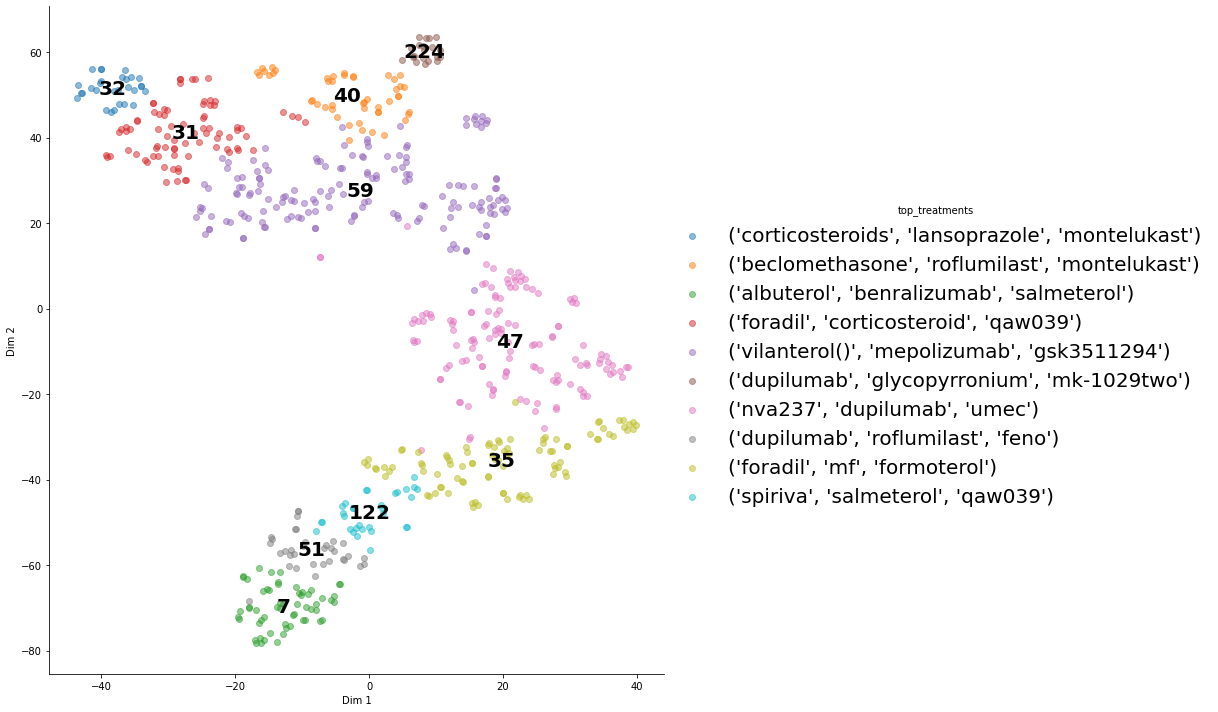

In [35]:
import matplotlib.pyplot as plt

# Add in the cluster labels
tsne_df = pd.DataFrame(x_embedded).rename(columns={0: 'Dim 1', 1: 'Dim 2'})
tsne_df['cluster'] = top_asthma_measures['cluster_label'].values

cluster_to_top = {}
for cluster in clusters_sorted:
  treatment_scores = cluster_to_treatment_scores[cluster]
  tuples = [(treat,score) for treat, score in treatment_scores.items()]
  tuples.sort(key= lambda x: x[1], reverse=False)
  top_5 = tuples[:5]
  cluster_to_top[cluster] = [x[0] for x in top_5[:3]]

tsne_df['top_treatments'] = tsne_df['cluster'].map(cluster_to_top).apply(tuple)

sns.FacetGrid(tsne_df, hue='top_treatments', height=10).map(plt.scatter, 'Dim 1', 'Dim 2', alpha=.5).add_legend(fontsize=20)

for cluster in clusters_sorted:
    plt.annotate(cluster, 
                 tsne_df.loc[tsne_df['cluster']==cluster,['Dim 1','Dim 2']].mean(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold') 
    
plt.show()

In [ ]:
## Can we get some other measurements here?? Like maybe number of studies saying it 


In [36]:
## Get an idea of the textual measures behind each one
asthma_rows_clustered[asthma_rows_clustered['cluster_label']==224]['measure_description'].unique()

array(['A severe exacerbation was defined as a deterioration of asthma requiring: use of systemic corticosteroids for >=3 days; or hospitalization or emergency room visit because of asthma, requiring systemic corticosteroids. Annualized event rate was the total number of exacerbations that occurred during the treatment period divided by the total number of participant-years treated.',
       "An asthma attack was defined as asthma symptoms during the previous 24 hours requiring one or more of the following: corticosteroid use (systemic), unscheduled visit to the doctor or urgent care clinic, unscheduled visit to the emergency department or hospitalization. Information on asthma attacks was recorded throughout the study in the participant's e-Diary, and an Analysis of Variance (ANOVA) was used to calculate the average percentage of asthma attack days over Week 6 to Week 12 of a 12-week treatment period.",
       'Severe asthma exacerbation refers to an occurrence of a decrease below 80%

In [37]:
asthma_rows_clustered[asthma_rows_clustered['cluster_label']==47]['measure_description'].unique()

array(["FEV1 is the amount of air, measured in liters, forcibly exhaled in 1 second. Pulmonary function tests were to be performed by participants in the morning before dosing. The percent predicted FEV1 equals the participant's observed FEV1 divided by the participant's predicted FEV1 (determined by height and race) and converted to a percentage by multiplying by 100%. The goal of the primary outcome measure was to compare the change from Baseline in AM FEV1 between the MF MDI and Placebo treatment groups. The comparison between the MF MDI 50 mcg BID vs. MF DPI 100 mcg QD treatment groups is presented in a subsequent outcome measure.",
       "FEV1 is the amount of air, measured in liters, forcibly exhaled in 1 second. Pulmonary function tests were to be performed by participants in the morning before dosing. The percent predicted FEV1 equals the participant's observed FEV1 divided by the participant's predicted FEV1 (determined by height and race) and converted to a percentage by mul

In [39]:
asthma_rows_clustered[asthma_rows_clustered['cluster_label']==51]['measure_description'].unique()


array(['This was defined as the mean +/- standard deviation of FEV1 in each group (treatment with budesonide versus usual care.',
       'daily AM peak expiratory flow (PEF) measured in liters per minute',
       'Forced expiratory volume in one second (FEV1) from spirometry',
       'Mean change in pre-bronchodilator FEV1 - forced expiratory volume in 1 second; a measure of pulmonary function. The treatment effect is the difference in the mean change in between the groups.',
       'FEV1 is the volume of air that can forcibly be blown out in one second, after full inspiration. Pooled SDs and LS means were calculated based on an ANOVA model.',
       'Spirometry was performed according to local standards. FEV1 is the maximal amount of air forcefully exhaled from the lungs in one second. Higher change numbers indicate better lung function.',
       'Airway reactivity will be measured with methacholine challenge testing following ATS guidelines.\n\nThis is the concentration of methacholi